In [1]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
import pickle

In [2]:
def preprocess_text(text):
    # minusculas
    text = text.lower()
    
    # Eliminar puntuación
    text = ''.join([char for char in text if char not in string.punctuation])

    # Eliminar cadenas con más de dos 'X' consecutivas
    text = re.sub(r'x{2,}', '', text)

    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    
    # Tokenización
    words = nltk.word_tokenize(text)
    
    # Eliminar stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    
    # Lematización
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    
    # Unir las palabras preprocesadas
    return ' '.join(words)

In [3]:
df = pd.read_csv("../data/clean/processed_data.csv")
df

,complaint_what_happened,ticket_classification
0,Good morning my name is XXXX XXXX and I apprec...,Debt collection + Credit card debt
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Credit card or prepaid card + General-purpose ...
2,Chase Card was reported on XX/XX/2019. However...,"Credit reporting, credit repair services, or o..."
3,"On XX/XX/2018, while trying to book a XXXX XX...","Credit reporting, credit repair services, or o..."
4,my grand son give me check for {$1600.00} i de...,Checking or savings account + Checking account
...,...,...
18958,My husband passed away. Chase bank put check o...,Checking or savings account + Checking account
18959,After being a Chase Card customer for well ove...,Credit card or prepaid card + General-purpose ...
18960,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",Credit card or prepaid card + General-purpose ...
18961,I am not familiar with XXXX pay and did not un...,Checking or savings account + Checking account


In [4]:
df['complaint_what_happened'] = df['complaint_what_happened'].apply(preprocess_text)
df['ticket_classification'] = df['ticket_classification'].apply(preprocess_text)

In [5]:
X = df['complaint_what_happened']
y = df['ticket_classification']

label_encoder = LabelEncoder()

y = label_encoder.fit_transform(y)
tfidf = TfidfVectorizer()

X = tfidf.fit_transform(X)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

In [7]:
import dagshub
import mlflow

dagshub.init(repo_owner='zapatacc', repo_name='final-exam-pcd2024-autumn', mlflow=True)
TRACKING_URI = mlflow.get_tracking_uri()
mlflow.set_tracking_uri(TRACKING_URI)
mlflow.set_experiment("mariapaula-perez-experiments") # Guarda MI experimento 

Accessing as Maria-Paula-PR

Initialized MLflow to track repo "zapatacc/final-exam-pcd2024-autumn"

Repository zapatacc/final-exam-pcd2024-autumn initialized!

<Experiment: artifact_location='mlflow-artifacts:/325528813677435a86c03d4a3fd51d45', creation_time=1732229152759, experiment_id='25', last_update_time=1732229152759, lifecycle_stage='active', name='mariapaula-perez-experiments', tags={}>

In [11]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

# Diccionario de modelos con parámetros
models_gridSearch = {
    "SVC": {
        "model": SVC(),
        "params": {
            "C": [2],           # Regularización
            "kernel": ["linear"], # Tipos de kernel
            "gamma": ["auto"]   # Coeficiente del kernel
        }
    },
    "LogisticRegression": {
        "model": LogisticRegression(),
        "params": {
            "C": [0.1, 1, 10],          # Regularización
            "solver": ["liblinear"], # Algoritmo de optimización
            "penalty": ["l2"]           # Tipo de penalización
        }
    }
}

In [12]:
model = models_gridSearch["SVC"]["model"]
params = models_gridSearch["SVC"]["params"]
grid = GridSearchCV(model, params, scoring="accuracy", cv=3)

with mlflow.start_run(run_name="mariapaula-perez-SVC"):
    grid.fit(X_train,y_train)
    model = grid.best_estimator_
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test,y_pred)

    with open ("LabelEncoder.pkl", "wb") as file:
        pickle.dump(label_encoder, file)
    mlflow.log_artifact("LabelEncoder.pkl")

    
    with open ("TfidfVectorizer.pkl", "wb") as file:
        pickle.dump(tfidf, file)
    mlflow.log_artifact("TfidfVectorizer.pkl")

    ## Log del modelo
    mlflow.log_params(grid.best_params_)
    mlflow.log_metric("accuracy", accuracy)

    mlflow.sklearn.log_model(model, artifact_path=f"SVC-maripau")

2024/11/22 14:39:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/22 14:39:26 INFO mlflow.tracking._tracking_service.client: 🏃 View run mariapaula-perez-SVC at: https://dagshub.com/zapatacc/final-exam-pcd2024-autumn.mlflow/#/experiments/25/runs/5bc094ebc6d04ff38f9fedb22573ab25.
2024/11/22 14:39:26 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/zapatacc/final-exam-pcd2024-autumn.mlflow/#/experiments/25.


In [13]:
model = models_gridSearch["LogisticRegression"]["model"]
params = models_gridSearch["LogisticRegression"]["params"]
grid = GridSearchCV(model, params, scoring="accuracy", cv=3)

with mlflow.start_run(run_name="mariapaula-perez-LogisticRegression"):
    grid.fit(X_train,y_train)
    model = grid.best_estimator_
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test,y_pred)

    with open ("LabelEncoder.pkl", "wb") as file:
        pickle.dump(label_encoder, file)
    mlflow.log_artifact("LabelEncoder.pkl")

    
    with open ("TfidfVectorizer.pkl", "wb") as file:
        pickle.dump(tfidf, file)
    mlflow.log_artifact("TfidfVectorizer.pkl")

    ## Log del modelo
    mlflow.log_params(grid.best_params_)
    mlflow.log_metric("accuracy", accuracy)

    mlflow.sklearn.log_model(model, artifact_path=f"LogisticRegression-maripau")

2024/11/22 14:41:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/22 14:41:33 INFO mlflow.tracking._tracking_service.client: 🏃 View run mariapaula-perez-LogisticRegression at: https://dagshub.com/zapatacc/final-exam-pcd2024-autumn.mlflow/#/experiments/25/runs/48e8942b706e4f47bba82002f720db93.
2024/11/22 14:41:33 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/zapatacc/final-exam-pcd2024-autumn.mlflow/#/experiments/25.


De los dos modelos el que dio un accuracy levemente mejor fue el SVC con 59 %.

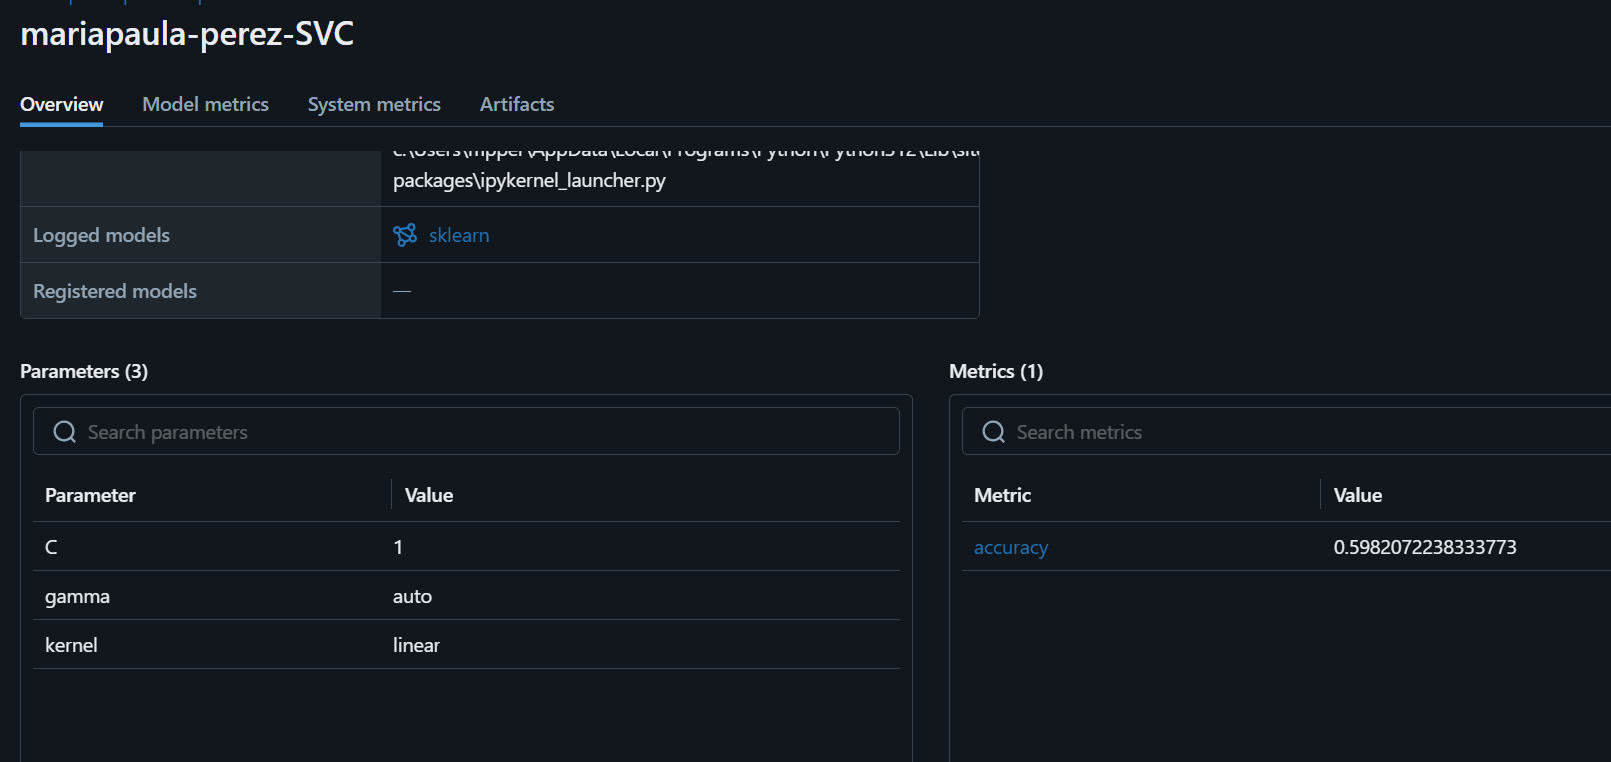

El siguiente paso es hacer el flow en un documento que se llamará train.py, tambien se le asignará al mejor modelo el alias champion. Ahí se ejecutarán los modelos en prefect. Para posteriormente poder hacer la app con streamlit.